# Basic usage of the package

Begin with creating a database connection object. Depending on the arguments you provide to the object constructor, the database will be created either in-memory, at a default location (which is `cwd`) or at the user specified location. Regardles of the choice, the necessary tables will also be created, if do not yet exist. 

In [1]:
from gensor.db import DatabaseConnection

# Crearing a database connection object and the database itself in the default location
db = DatabaseConnection()

## Uploading the data to the SQLite database

GWLoggerPy is designed in a way assuring as few exceptions as possible, so we are working with `Path` objects instead of simple strings.

#### What do the van Essen Instruments loggers measure?
The loggers measure the abolute pressure at the membrane of the sensor, therefore the datasets require compensation for barometric pressure.

#### How the data from van Essen instruments is collected?
If the loggers are not equipped with some kind of telemetric system (which is the case most of the times), it is necessary to go to the field once in a while and collect the data. That is done either with a laptop (using DiverOffice or DiverField software) or a small handheld device called DiverMate and an Android device. Each time the data is collected, a timeseries is generated (that includes old records that may have been already collected before and are stored in another CSV file).
Normall, in Project Grow we collect the data every two months with DiverMate and then share the CSV files to Google Drive. Each time we export the data, we end up with a new CSV file that need to be merged to obtain a consistent timeseries. 

### Loading files

The `load_from_csv()` function provides a relief of dealing with numerous files. It can load a single CSV file, but it can also scan a directory and load all files in that directory.
The loggers we use in Project Grow record temerature and pressure, but there are also other products that can measure electricul conductivity as well. In the CSV file each timeseries is saved in a separate column. `load_from_csv()` function splits the columns into individual timeseries and creates a list of `Timeseries` objects.

*Note: In the vanessen file, the metadata of the diver and the station it is deployed to is stored in the header of the file. To extract those from all the files, I used regex. It is important that the user knows the naming patterns of the stations and replace the default pattern using a kwarg `location_pattern`. It is possible to add an OR (|) operator to try matching multiple patterns. For us, the following pattern matches all substrings that start with two letters, have two numbers in the middle and end with one letter or include a string 'Barodived' `pattern = r'[A-Za-z]{2}\d{2}[A-Za-z]{1}|Barodiver'`*

In [1]:
from pathlib import Path

test_data = Path('/mnt/g/My Drive/Kinrooi_FieldData/DiverMate/CSV')

Loading file: /mnt/g/My Drive/Kinrooi_FieldData/DiverMate/CSV/BY222_Barodiver_20240226112663.CSV
Loading file: /mnt/g/My Drive/Kinrooi_FieldData/DiverMate/CSV/AZ042_PB15A_moni_AZ042_20240226112690.CSV
Loading file: /mnt/g/My Drive/Kinrooi_FieldData/DiverMate/CSV/AY969_PB16C_moni_AY969_20240226114540.CSV
Loading file: /mnt/g/My Drive/Kinrooi_FieldData/DiverMate/CSV/AZ042_PB15A_moni_AZ042_20240305052142.CSV


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Pressure at Barodiver'}, xlabel='Time', ylabel='pressure (cmH2O)'>)

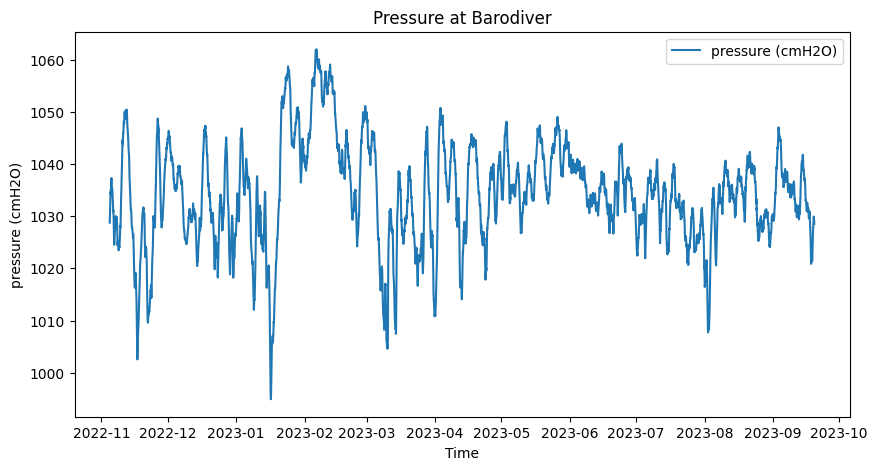

In [2]:
from gensor import read_from_csv

pattern = r'[A-Za-z]{2}\d{2}[A-Za-z]{1}|Barodiver'

data = read_from_csv(path=test_data, 
                    file_format='vanessen', 
                    location_pattern=pattern)

data[0].plot()

## SQLite itegration

### Saving the data to the SQLite database

The `Timeseries` object has `Timeseries.to_sql()` method. Therefore, it is really easy to save each item to the database by calling the method in a loop for all objects.

In [8]:
# TBC

### Getting data from SQLite database

In [2]:
# TBC


## Compensation

To compensate the measurements from an absolute pressure sensor for atmospheric pressure we need to do two things:
- Identify the atmospheric pressure timeseries
- Include the sensor elevation in the submerged sensor timeseries

In [3]:
# identify the barometric timeseries in your dataset
baro = data.filter(station='Barodiver', variable='pressure')
baro

Timeseries(variable='pressure', unit='cmH2O', location='Barodiver', sensor='BY222', sensor_alt=None)

In [4]:
# Adding extra information to the submerged sensor timeseries
pb15a = data.filter(station='PB15A', variable='pressure')
pb15a

Timeseries(variable='pressure', unit='cmH2O', location='PB15A', sensor='AZ042', sensor_alt=None)

In [5]:
pb15a.sensor_alt = 33.36

10 records                     dropped due to low water column.


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Head at PB15A'}, xlabel='Time', ylabel='head (m asl)'>)

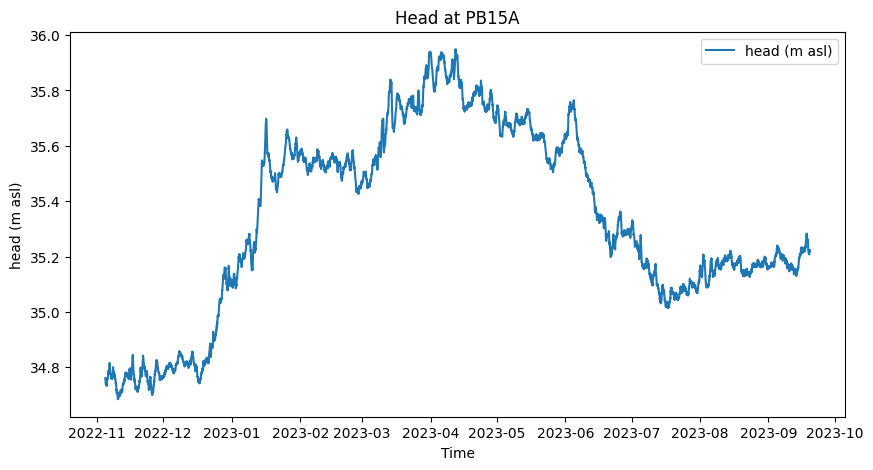

In [13]:
from gensor import compensate

pb15a_comp = compensate(pb15a, baro, drop_low_wc=True)
pb15a_comp.plot()